# Init

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.vector_ar.var_model import VAR
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from math import sqrt

import warnings

warnings.filterwarnings('ignore')

In [2]:
data_path = 'data.csv'

df = pd.read_csv(data_path)

# Inspect Data

In [3]:
df.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,283996800,1979-01-01 00:00:00 +0000 UTC,10800,Nazilli,37.909777,28.324294,16.70,NaN,13.80,16.59,...,NaN,NaN,NaN,NaN,NaN,67,803,Clouds,broken clouds,04n
1,284000400,1979-01-01 01:00:00 +0000 UTC,10800,Nazilli,37.909777,28.324294,16.68,NaN,14.15,16.62,...,NaN,NaN,NaN,NaN,NaN,85,804,Clouds,overcast clouds,04n
2,284004000,1979-01-01 02:00:00 +0000 UTC,10800,Nazilli,37.909777,28.324294,16.35,NaN,14.00,16.29,...,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
3,284007600,1979-01-01 03:00:00 +0000 UTC,10800,Nazilli,37.909777,28.324294,17.35,NaN,15.17,17.41,...,NaN,NaN,NaN,NaN,NaN,99,804,Clouds,overcast clouds,04n
4,284011200,1979-01-01 04:00:00 +0000 UTC,10800,Nazilli,37.909777,28.324294,17.47,NaN,15.10,17.52,...,NaN,NaN,NaN,NaN,NaN,97,804,Clouds,overcast clouds,04n


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385584 entries, 0 to 385583
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   385584 non-null  int64  
 1   dt_iso               385584 non-null  object 
 2   timezone             385584 non-null  int64  
 3   city_name            385584 non-null  object 
 4   lat                  385584 non-null  float64
 5   lon                  385584 non-null  float64
 6   temp                 385584 non-null  float64
 7   visibility           0 non-null       float64
 8   dew_point            385584 non-null  float64
 9   feels_like           385584 non-null  float64
 10  temp_min             385584 non-null  float64
 11  temp_max             385584 non-null  float64
 12  pressure             385584 non-null  int64  
 13  sea_level            0 non-null       float64
 14  grnd_level           0 non-null       float64
 15  humidity         

# Remove unnecessary columns

## Drop mostly NaN columns

Since I got the data from OpenWeather, all the features are already clean and mostly non null.

The columns that contain null are mostly null too.

So we will just drop them.

In [5]:
df.dropna(axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385584 entries, 0 to 385583
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   385584 non-null  int64  
 1   dt_iso               385584 non-null  object 
 2   timezone             385584 non-null  int64  
 3   city_name            385584 non-null  object 
 4   lat                  385584 non-null  float64
 5   lon                  385584 non-null  float64
 6   temp                 385584 non-null  float64
 7   dew_point            385584 non-null  float64
 8   feels_like           385584 non-null  float64
 9   temp_min             385584 non-null  float64
 10  temp_max             385584 non-null  float64
 11  pressure             385584 non-null  int64  
 12  humidity             385584 non-null  int64  
 13  wind_speed           385584 non-null  float64
 14  wind_deg             385584 non-null  int64  
 15  clouds_all       

## Drop duplicate or unnecessary columns

They don't contain any kind of valuable information, they're just there for representation of data. So we will drop them.

In [7]:
df.drop(['weather_id', 'weather_icon'], axis=1, inplace=True)


These have little to no variation, so deleting them would be the best

In [8]:
df.drop(['dt', 'timezone', 'city_name', 'lat', 'lon'], axis=1, inplace=True)

## Check for non-null seeming null values

In [9]:
df.describe()

,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all
count,385584.000000,385584.000000,385584.000000,385584.000000,385584.000000,385584.000000,385584.000000,385584.000000,385584.000000,385584.000000
mean,22.025581,12.700493,22.130577,18.830493,24.341804,1013.772760,59.494320,1.467998,156.185015,32.234084
std,9.146576,5.631505,10.030034,9.012102,9.195284,5.875017,19.123836,0.735305,105.699043,37.972288
min,-9.240000,-14.930000,-13.150000,-14.470000,-5.720000,977.000000,5.000000,0.000000,0.000000,0.000000
25%,14.950000,9.450000,14.450000,11.850000,17.170000,1010.000000,44.000000,0.960000,70.000000,0.000000
50%,21.530000,13.230000,21.380000,18.320000,23.900000,1013.000000,60.000000,1.410000,110.000000,10.000000
75%,28.970000,16.800000,29.340000,25.600000,31.470000,1018.000000,76.000000,1.850000,266.000000,68.000000
max,47.400000,31.500000,53.060000,44.550000,49.440000,1037.000000,100.000000,6.730000,360.000000,100.000000


## Feature engineering

Properly handle timestamps

In [10]:
def sanitize_iso(string):
    string = string.split(' ')
    return ' '.join(string[:2])

df['dt_iso'] = df['dt_iso'].apply(sanitize_iso)
df['dt_iso'] = df['dt_iso'].apply(datetime.fromisoformat)
df['dt_iso'] = pd.to_datetime(df['dt_iso'])

df.index = df['dt_iso']
df.drop('dt_iso', axis=1, inplace=True)

In [11]:
df.head()

,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description
dt_iso,,,,,,,,,,,,
1979-01-01 00:00:00,16.70,13.80,16.59,14.47,18.55,1012,83,1.83,163,67,Clouds,broken clouds
1979-01-01 01:00:00,16.68,14.15,16.62,14.47,18.59,1011,85,1.66,157,85,Clouds,overcast clouds
1979-01-01 02:00:00,16.35,14.00,16.29,14.37,18.15,1012,86,1.89,170,75,Clouds,broken clouds
1979-01-01 03:00:00,17.35,15.17,17.41,15.34,19.09,1011,87,1.74,149,99,Clouds,overcast clouds
1979-01-01 04:00:00,17.47,15.10,17.52,15.21,19.25,1010,86,1.99,143,97,Clouds,overcast clouds


Properly handle wind_degree attribute since it is an interval.
1 degree and 359 degree are not that distant from each other. There are just 2 degrees between them.

In [12]:
df['wind_deg_sin'] = np.sin(df['wind_deg'])
df['wind_deg_cos'] = np.cos(df['wind_deg'])

df.drop('wind_deg', axis=1, inplace=True)

In [13]:
df.head()

,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all,weather_main,weather_description,wind_deg_sin,wind_deg_cos
dt_iso,,,,,,,,,,,,,
1979-01-01 00:00:00,16.70,13.80,16.59,14.47,18.55,1012,83,1.83,67,Clouds,broken clouds,-0.354910,0.934900
1979-01-01 01:00:00,16.68,14.15,16.62,14.47,18.59,1011,85,1.66,85,Clouds,overcast clouds,-0.079549,0.996831
1979-01-01 02:00:00,16.35,14.00,16.29,14.37,18.15,1012,86,1.89,75,Clouds,broken clouds,0.346649,0.937995
1979-01-01 03:00:00,17.35,15.17,17.41,15.34,19.09,1011,87,1.74,99,Clouds,overcast clouds,-0.974649,-0.223741
1979-01-01 04:00:00,17.47,15.10,17.52,15.21,19.25,1010,86,1.99,97,Clouds,overcast clouds,-0.998345,0.057503


# Save weather_description and weather_main for later and drop them too

We will train a XGBoost model to predict the description of our weather.

In [14]:
train_percent = 0.8

def train_xgb(df, label):

    clean_df = df.drop(['weather_main', 'weather_description'], axis=1)

    classifier = XGBClassifier()

    X = clean_df
    y = df[label]

    X_train, _, y_train, _ = train_test_split(X, y, train_size=train_percent, shuffle=False)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

    classifier = classifier.fit(X_train, y_train)
    return classifier, le

main_classifier, le_main = train_xgb(df, 'weather_main')
description_classifier, le_description = train_xgb(df, 'weather_description')


weather_main = df['weather_main']
weather_description = df['weather_description']

df.drop(['weather_main', 'weather_description'], axis=1, inplace=True)


# Time Series Analysis

In this section, we will first do a time series prediction (temperature, wind_speed etc.) to a given interval, and then use this prediction to predict another feature (weather description, like: 'heavy rain')

This may result in poor results since we're using a predicted feature to predict another one. But let's try to see what we can get or not.

In [15]:
steps = [1, 3, 24, 24 * 3, 24 * 7]
step_names = ('1 hour', '3 hour', '1 day', '3 day', '1 week')
iterations = 10
step_size = 0.01

def squared_error(x, y):
    return (x - y) ** 2

errors = np.zeros((len(steps), len(df.columns)))
general_forecast = {
    "type": [],
    "main": [],
    "main_pred": [],
    "description": [],
    "description_pred": [],
}

for i in range(iterations + 1):
    train_index = int(train_percent * len(df))
    train = df[:train_index]

    for j, step in enumerate(steps):
        test = df[train_index : train_index + step]
        test = test.to_numpy()

        var = VAR(endog=train)
        var = var.fit()

        pred = var.forecast(var.endog, step)

        x = test
        x_pred = pred

        y_main = weather_main[train_index + step - 1]
        y_description = weather_description[train_index + step - 1]

        y_main_pred = main_classifier.predict(x_pred)
        y_description_pred = description_classifier.predict(x_pred)

        y_main_pred = le_main.inverse_transform(y_main_pred)[-1]
        y_description_pred = le_description.inverse_transform(y_description_pred)[-1]

        general_forecast['type'].append(step_names[j])
        general_forecast['main'].append(y_main)
        general_forecast['main_pred'].append(y_main_pred)
        general_forecast['description'].append(y_description)
        general_forecast['description_pred'].append(y_description_pred)

        for k, (column, feature, feature_pred) in enumerate(zip(tuple(df.columns), x[-1], x_pred[-1])):
            errors[j][k] += sqrt(squared_error(feature, feature_pred))

    train_percent += step_size

errors /= iterations

errors = pd.DataFrame(data=errors, index=step_names, columns=df.columns)

RMSE's of each feature based on their time interval

We can see that our model was pretty bad at predicting wind degrees and cloud ratios.

This might result in poor weather prediction, like having 'clouds' predicted while the actual weather is 'clear'.

Other than that, it was quite good in 1 hour and 3 hour interval.

In [16]:
errors

,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all,wind_deg_sin,wind_deg_cos
1 hour,1.267022,0.604453,1.383803,1.099517,1.102828,0.247718,4.078178,0.129572,14.748122,0.584878,0.785303
3 hour,2.520337,1.379743,2.571608,1.804680,2.211870,0.943804,9.105610,0.391199,20.763857,0.737720,0.730271
1 day,3.960240,3.436053,4.860912,3.225771,4.015811,2.353749,12.861578,0.350027,27.311697,0.617626,0.686207
3 day,7.951743,6.393036,9.481014,6.948761,8.487645,5.157205,19.868634,0.735082,32.884429,0.324762,0.960794
1 week,6.824141,4.420727,7.783321,6.448758,6.932624,4.131047,17.774501,0.540027,36.960313,0.677559,0.656575


Here we see that errors increase as the time interval we're predicting increases.
An interesting thing to note is, weekly error rate is lower than 3 day error rate in almost all features.
This might indicate that there can be a weather trend that repeats weekly.

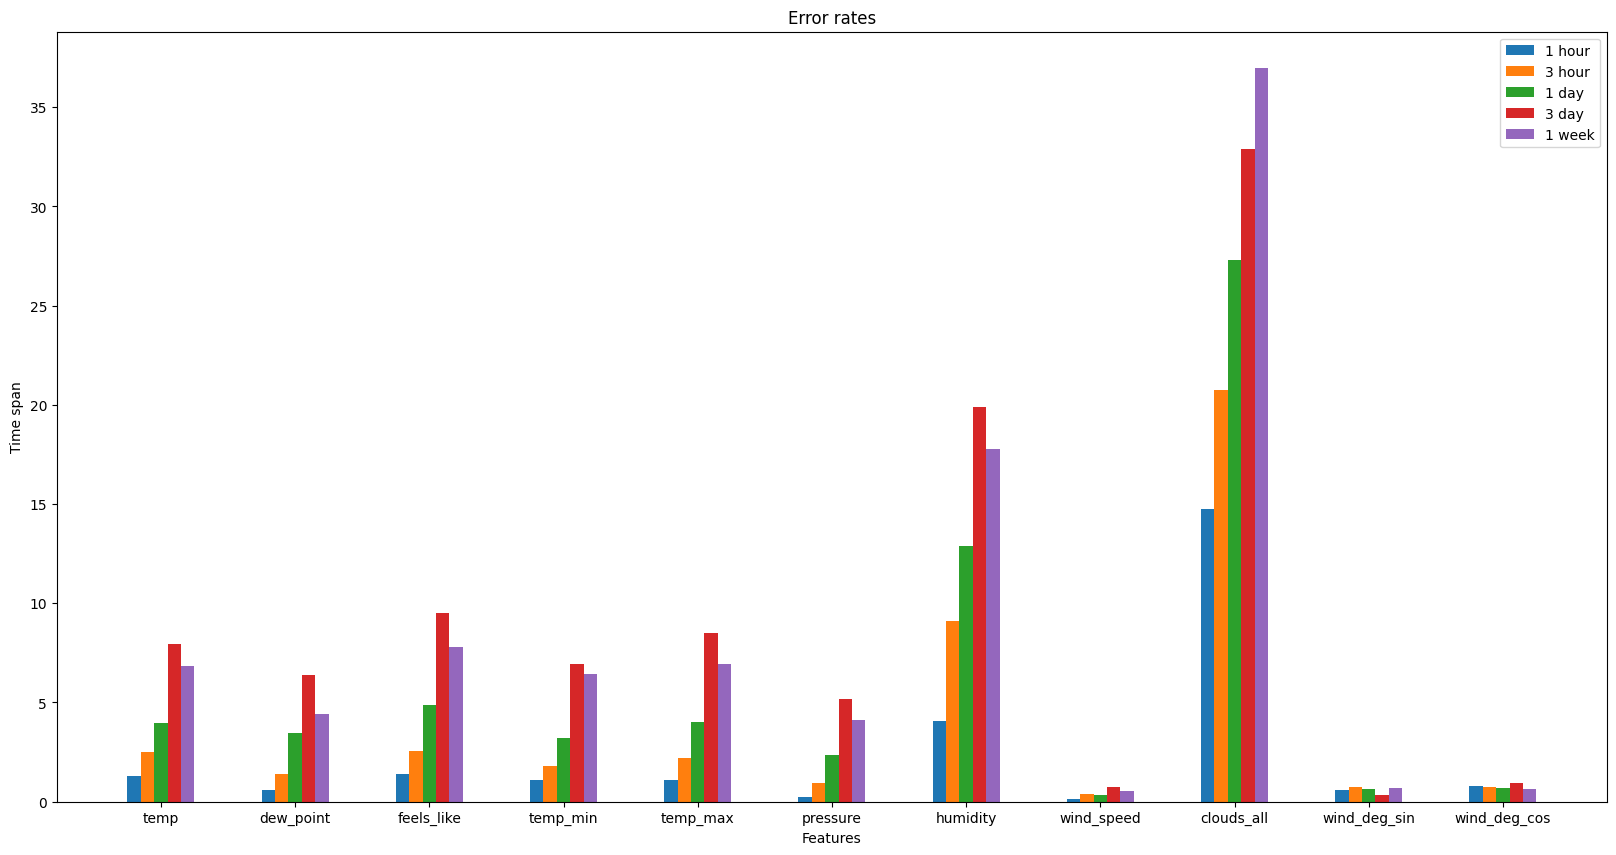

In [17]:
X = errors.columns
X_axis = np.arange(len(X))

plt.rcParams['figure.figsize'] = [20, 10]

plt.bar(X_axis - 0.2, errors.iloc[0], 0.1, label = '1 hour')
plt.bar(X_axis - 0.1, errors.iloc[1], 0.1, label = '3 hour')
plt.bar(X_axis - 0, errors.iloc[2], 0.1, label = '1 day')
plt.bar(X_axis + 0.1, errors.iloc[3], 0.1, label = '3 day')
plt.bar(X_axis + 0.2, errors.iloc[4], 0.1, label = '1 week')
  
plt.xticks(X_axis, X)
plt.xlabel('Features')
plt.ylabel('Time span')
plt.title('Error rates')

plt.legend()
plt.show()

In [18]:
forecast_df = pd.DataFrame(general_forecast)

1 hour and 3 hour predictions turned out to be quite good. They do miss sometimes, yes. But they don't say heavy rain to clear skies.

In [19]:
def plot_heatmap(forecast_type):
    contingency_matrix = pd.crosstab(forecast_df[forecast_df['type'] == forecast_type]['main'], forecast_df[forecast_df['type'] == forecast_type]['main_pred'])
    plt.clf()
    plt.title(f"{forecast_type} Forecast")
    fig = plt.gcf()
    fig.set_size_inches(24, 8)
    plt.subplot(121)
    sns.heatmap(contingency_matrix.T, annot=True)
    plt.subplot(122)
    contingency_matrix = pd.crosstab(forecast_df[forecast_df['type'] == forecast_type]['description'], forecast_df[forecast_df['type'] == forecast_type]['description_pred'])
    sns.heatmap(contingency_matrix.T, annot=True)
    plt.show()

In [20]:
forecast_df[forecast_df['type'] == '1 hour']

,type,main,main_pred,description,description_pred
0,1 hour,Clouds,Clouds,scattered clouds,light rain
5,1 hour,Clouds,Clouds,few clouds,scattered clouds
10,1 hour,Clouds,Clouds,broken clouds,overcast clouds
15,1 hour,Clear,Clear,sky is clear,sky is clear
20,1 hour,Clear,Clear,sky is clear,sky is clear
25,1 hour,Clouds,Clouds,broken clouds,scattered clouds
30,1 hour,Clear,Clouds,sky is clear,broken clouds
35,1 hour,Clouds,Clouds,scattered clouds,scattered clouds
40,1 hour,Clear,Clear,sky is clear,sky is clear
45,1 hour,Rain,Rain,light rain,overcast clouds


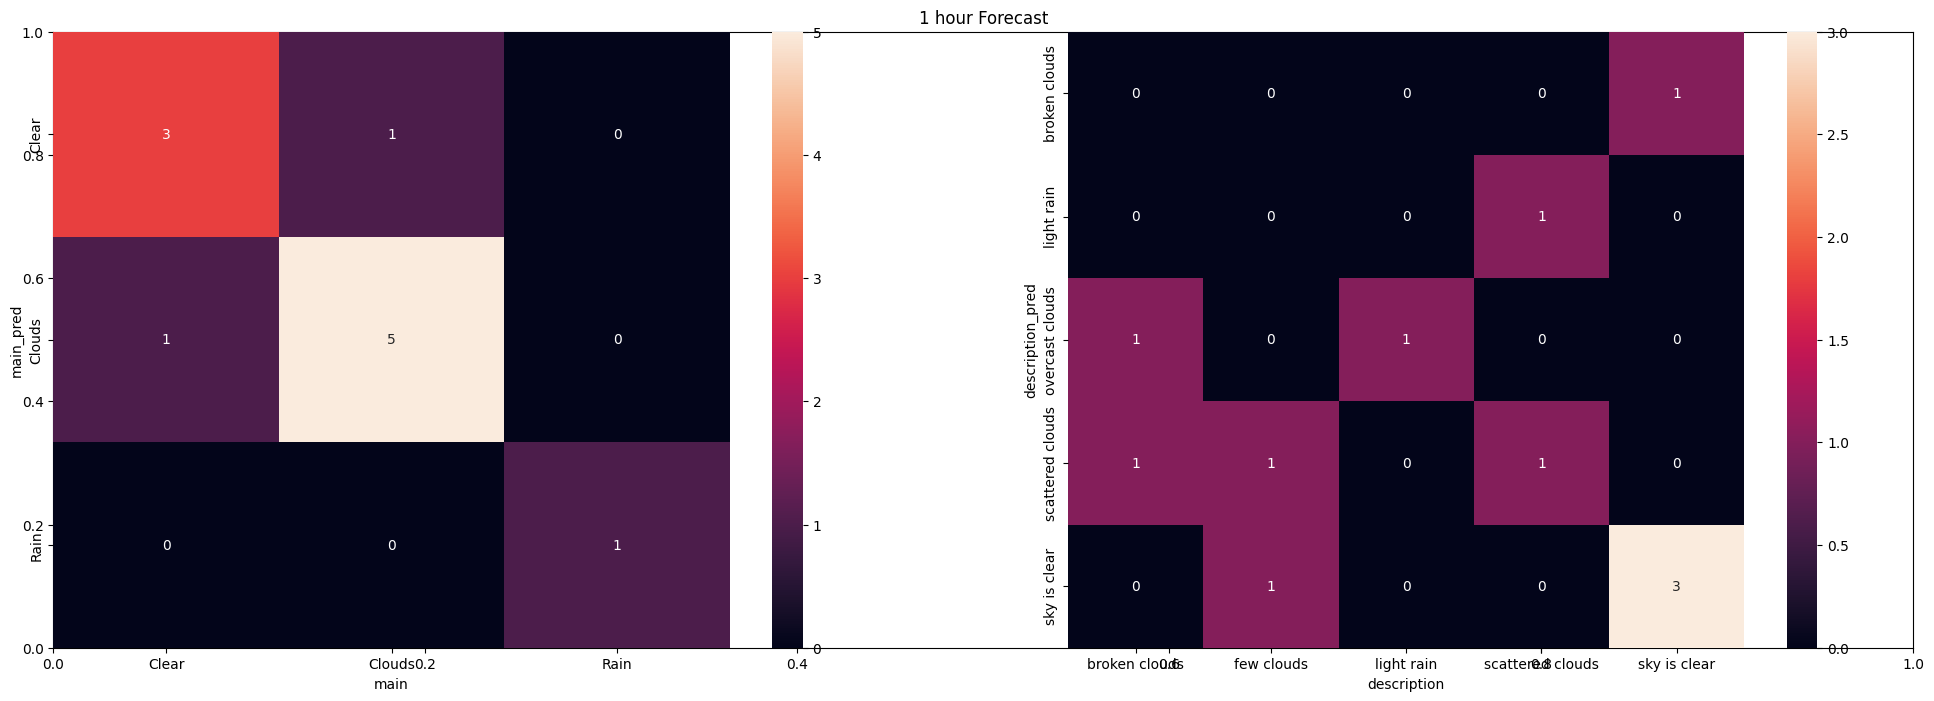

In [21]:
plot_heatmap('1 hour')

In [22]:
forecast_df[forecast_df['type'] == '3 hour']

,type,main,main_pred,description,description_pred
1,3 hour,Clouds,Clouds,broken clouds,light rain
6,3 hour,Clouds,Clouds,few clouds,few clouds
11,3 hour,Clouds,Clouds,broken clouds,overcast clouds
16,3 hour,Clear,Clear,sky is clear,sky is clear
21,3 hour,Clear,Clear,sky is clear,sky is clear
26,3 hour,Rain,Clouds,light rain,scattered clouds
31,3 hour,Clear,Clouds,sky is clear,broken clouds
36,3 hour,Clouds,Clouds,scattered clouds,scattered clouds
41,3 hour,Clear,Clear,sky is clear,sky is clear
46,3 hour,Clouds,Clouds,scattered clouds,overcast clouds


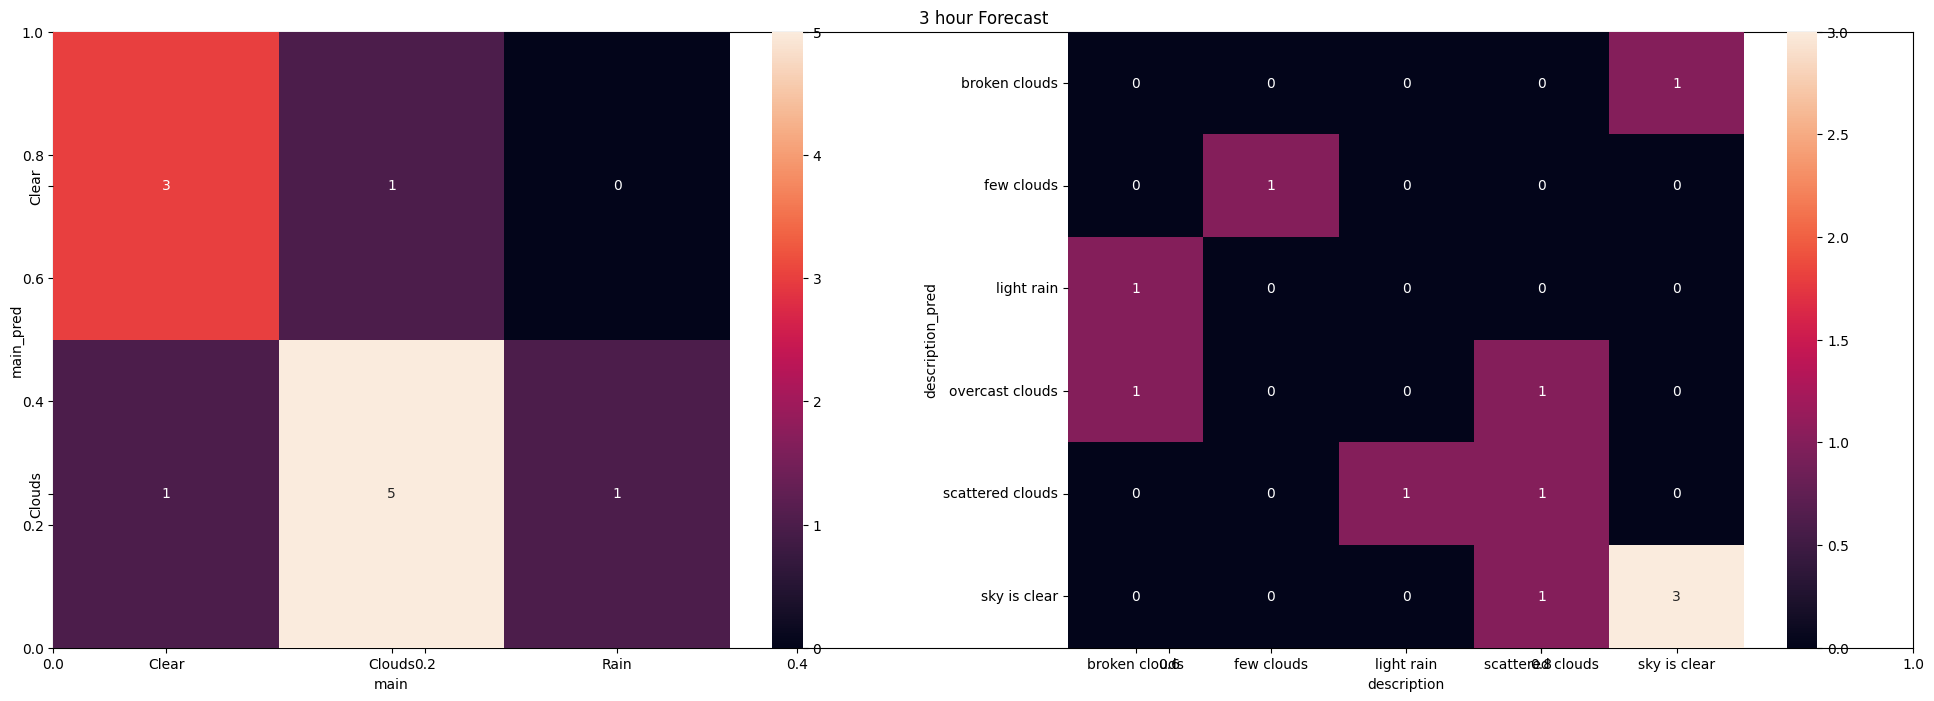

In [23]:
plot_heatmap('3 hour')

1 day forecasting is somewhere between. It's not good as hourly predictions but it's not bad as 3 day or weekly forecasts.

In [24]:
forecast_df[forecast_df['type'] == '1 day']

,type,main,main_pred,description,description_pred
2,1 day,Clouds,Clouds,broken clouds,scattered clouds
7,1 day,Clear,Clouds,sky is clear,few clouds
12,1 day,Clouds,Clouds,scattered clouds,broken clouds
17,1 day,Clear,Clouds,sky is clear,few clouds
22,1 day,Clear,Clouds,sky is clear,few clouds
27,1 day,Clouds,Clouds,broken clouds,scattered clouds
32,1 day,Clear,Clouds,sky is clear,scattered clouds
37,1 day,Clouds,Clouds,scattered clouds,scattered clouds
42,1 day,Clear,Clouds,sky is clear,few clouds
47,1 day,Rain,Clouds,moderate rain,broken clouds


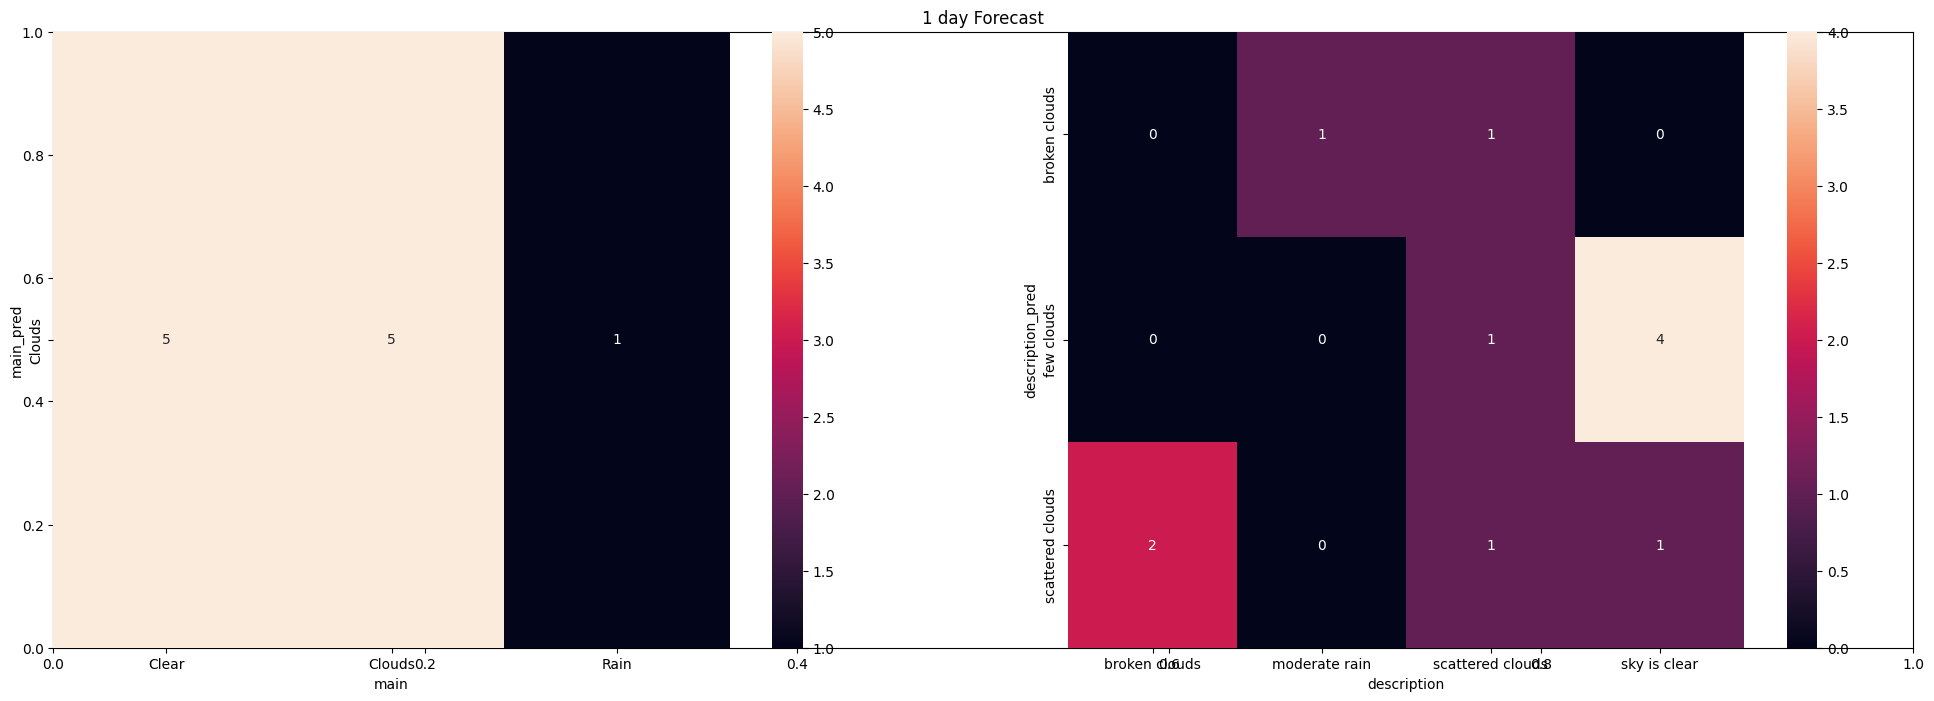

In [25]:
plot_heatmap('1 day')

1 week and 3 day forecast is not so efficient since we have some error with the prediction of features and we're using these biased features to predict a new feature. These errors cumulate in time.

In [26]:
forecast_df[forecast_df['type'] == '3 day']

,type,main,main_pred,description,description_pred
3,3 day,Clear,Clouds,sky is clear,scattered clouds
8,3 day,Clear,Clouds,sky is clear,scattered clouds
13,3 day,Clouds,Clouds,overcast clouds,scattered clouds
18,3 day,Clouds,Clouds,few clouds,scattered clouds
23,3 day,Clouds,Clouds,scattered clouds,scattered clouds
28,3 day,Clouds,Clouds,scattered clouds,scattered clouds
33,3 day,Clear,Clouds,sky is clear,scattered clouds
38,3 day,Clear,Clouds,sky is clear,scattered clouds
43,3 day,Clear,Clouds,sky is clear,scattered clouds
48,3 day,Rain,Clouds,moderate rain,scattered clouds


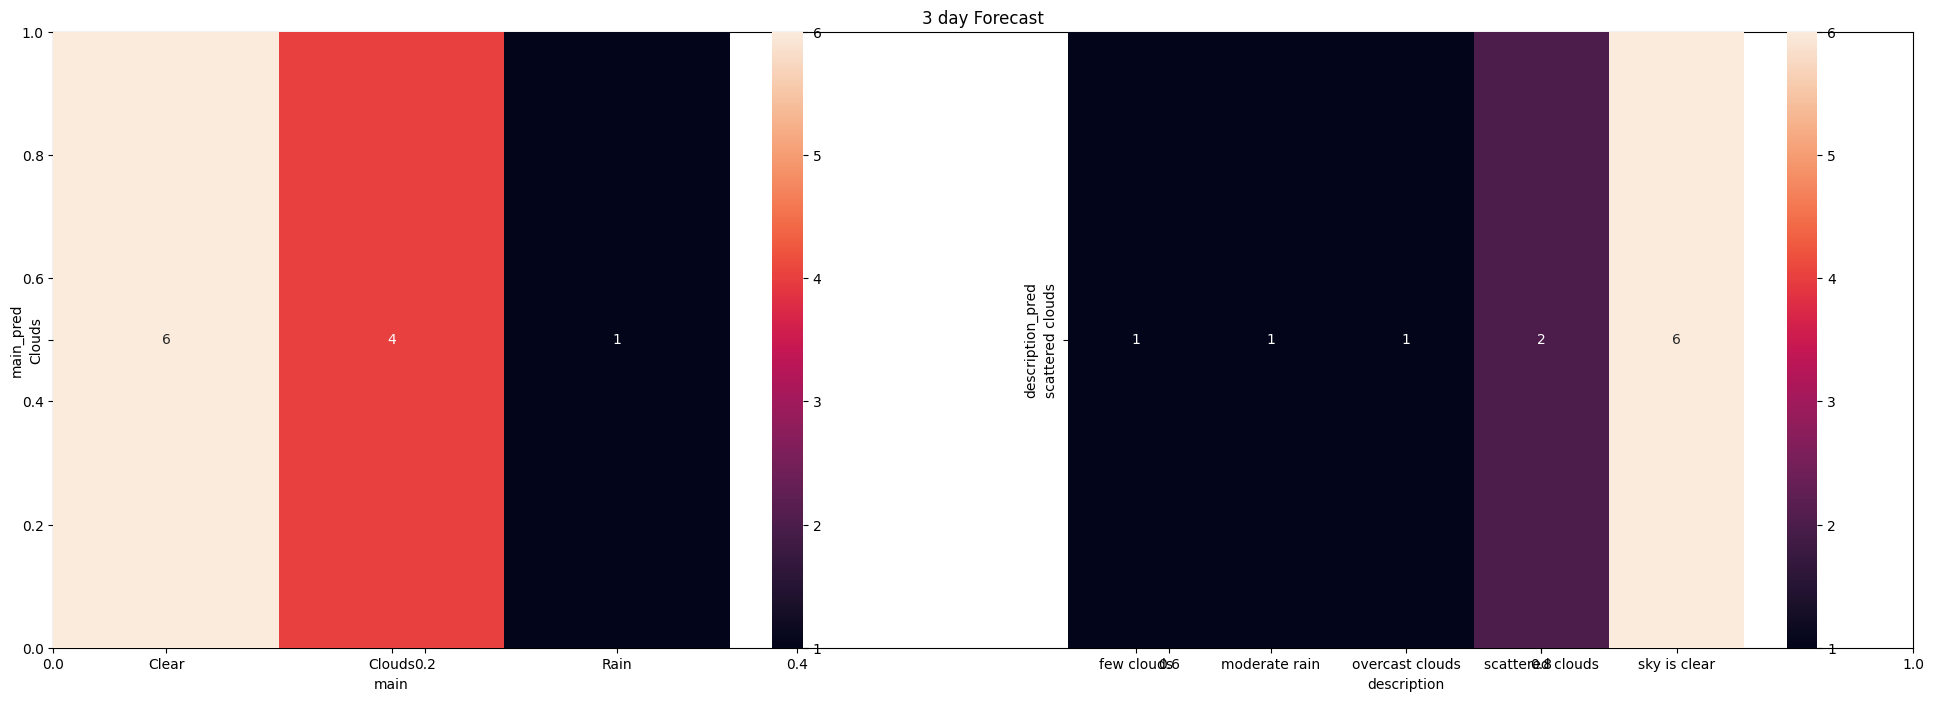

In [27]:
plot_heatmap('3 day')

In [28]:
forecast_df[forecast_df['type'] == '1 week']

,type,main,main_pred,description,description_pred
4,1 week,Clear,Clouds,sky is clear,scattered clouds
9,1 week,Clear,Clouds,sky is clear,scattered clouds
14,1 week,Clear,Clouds,sky is clear,scattered clouds
19,1 week,Clear,Clouds,sky is clear,scattered clouds
24,1 week,Clear,Clouds,sky is clear,scattered clouds
29,1 week,Clear,Clouds,sky is clear,scattered clouds
34,1 week,Clear,Clouds,sky is clear,scattered clouds
39,1 week,Clear,Clouds,sky is clear,scattered clouds
44,1 week,Clear,Clouds,sky is clear,scattered clouds
49,1 week,Rain,Clouds,light rain,scattered clouds


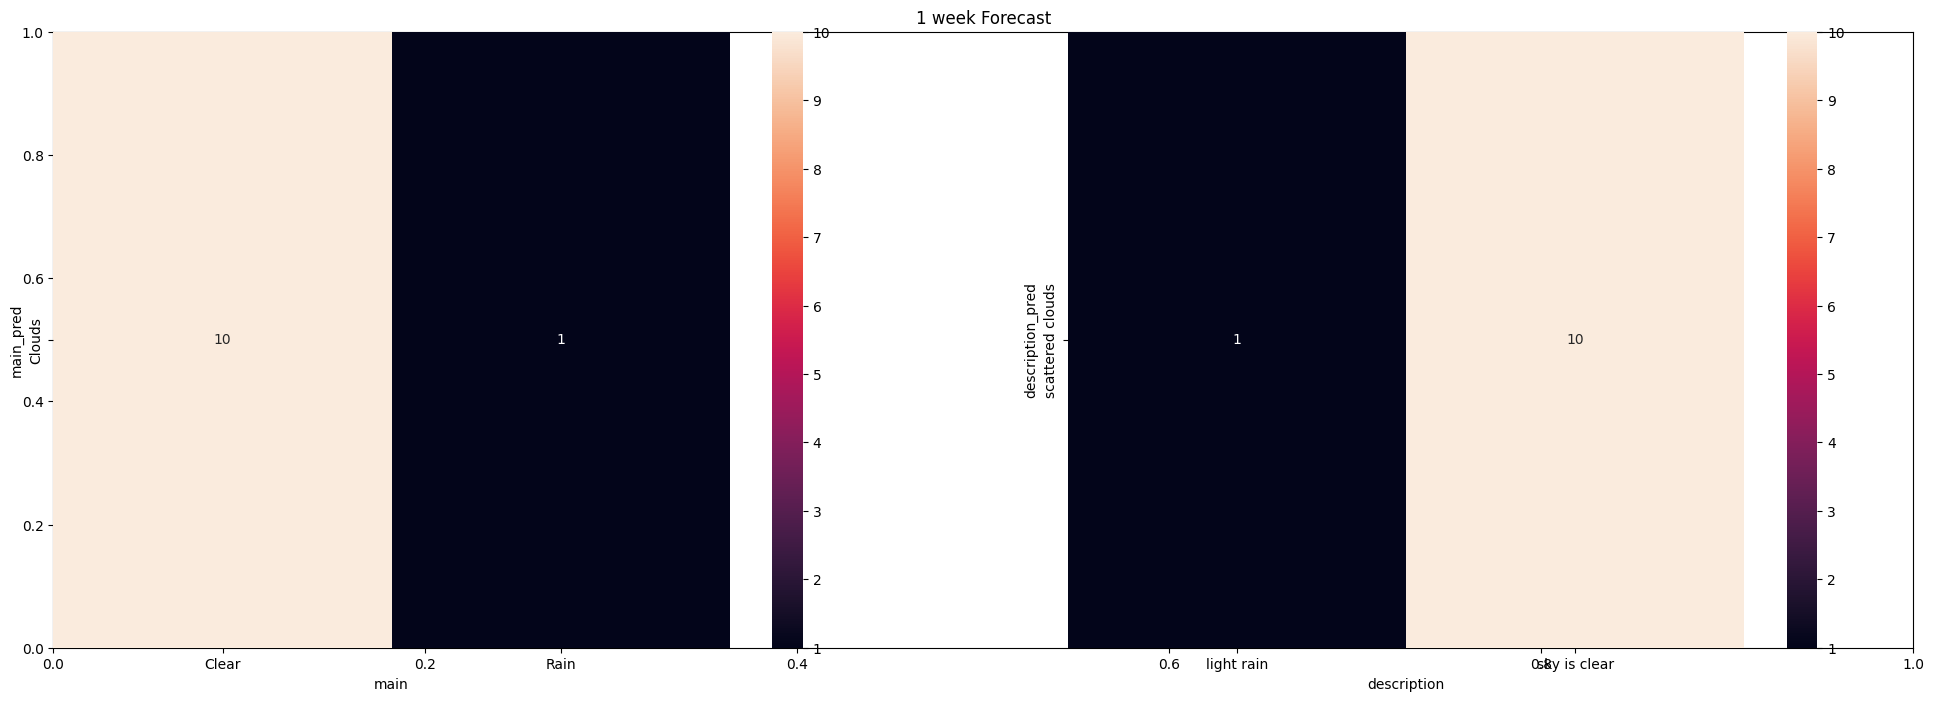

In [29]:
plot_heatmap('1 week')